# JupyterGIS demo

## Outline

* Aggregate gridded data based on vector regions (e.g. neighborhoods)
  * Not straightforward to do in Python
* Design:
  * Start in a Notebook, prepared with Maryam’s expertise
  * Loading GeoPandas, tools for Zonal Statistics
  * Programmatically create .jGIS document, add input data sources and output data sources.
  * Demonstrate collaboration of JGIS alongside Notebook. Annotation, ad layer from catalog, etc.

In [90]:
DATA_DIR = Path().cwd() / "data"

## From geopythontutorials.com

### Resources

* https://www.geopythontutorials.com/notebooks/xarray_zonal_stats.html?utm_source=chatgpt.com#data-pre-processing
* Carl's class
  * https://espm-288.carlboettiger.info/tutorials/python/spatial-2.html
  * https://espm-288.carlboettiger.info/tutorials/python/spatial-1.html
  * https://espm-288.carlboettiger.info/tutorials/python/spatial-3.html
  * https://espm-288.carlboettiger.info/tutorials/python/spatial-4.html
* https://carpentries-incubator.github.io/geospatial-python/10-zonal-statistics.html
* https://medium.com/data-science/zonal-statistics-algorithm-with-python-in-4-steps-382a3b66648a
* https://automating-gis-processes.github.io/CSC18/lessons/L6/zonal-statistics.html

https://www.geopythontutorials.com/notebooks/xarray_zonal_stats.html?utm_source=chatgpt.com

New dependencies

* rioxarray
* geocube
* xarray-spatial

### Download the data

In [ ]:
import os

data_folder = "data"

def download(url, data_folder):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

raster_file = 'chirps-v2.0.2021.tif'
zones_file = 'cb_2021_us_county_500k.zip'

files = [
    'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_annual/tifs/' + raster_file,
    'https://www2.census.gov/geo/tiger/GENZ2021/shp/' + zones_file,
]

for file in files:
  download(file, data_folder)

### Data pre-processing

In [ ]:
import geopandas as gpd

zones_file_path = os.path.join(data_folder, zones_file)

zones_df = gpd.read_file(zones_file_path)
# TODO: Louisiana instead?
california_df  = zones_df[zones_df['STATE_NAME'] == 'California'].copy()
california_df.iloc[:5, :5]

In [ ]:
california_df['GEOID'] = california_df.GEOID.astype(int)

In [ ]:
import rioxarray as rxr

raster_filepath = os.path.join(data_folder, raster_file)
raster = rxr.open_rasterio(raster_filepath, mask_and_scale=True)
clipped = raster.rio.clip(california_df.geometry)
clipped

In [ ]:
precipitation = clipped.sel(band=1)
precipitation

In [ ]:
from geocube.api.core import make_geocube

california_raster = make_geocube(
    vector_data=california_df,
    measurements=['GEOID'],
    like=precipitation,
)
california_raster

In [ ]:
from xrspatial import zonal_stats

stats_df = zonal_stats(zones=california_raster.GEOID, values=precipitation)
stats_df.iloc[:5]

In [ ]:
stats_df['GEOID'] = stats_df['zone'].astype(int)

In [ ]:
joined = california_df.merge(stats_df[['GEOID', 'mean']], on='GEOID')
joined.iloc[:5, -5:]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)

legend_kwds={
           'orientation': 'horizontal',  # Make the legend horizontal
           'shrink': 0.5,  # Reduce the size of the legend bar by 50%
           'pad': 0.05,  # Add some padding around the legend
           'label': 'Precipitation (mm)',  # Set the legend label (optional)
       }
joined.plot(ax=ax, column='mean', cmap='Blues',
          legend=True, legend_kwds=legend_kwds)
ax.set_axis_off()
ax.set_title('Total Precipitation 2021 for California Counties')
plt.show()

In [ ]:
joined.explore()

## From Carl's class

New dependencies (don't add to environment, this is just for accessing data):

* ibis-duckdb
* odc-stac
* cmasher

New dependencies (add to environment):

* exactextract

### Setting up vector data (neighborhoods)

https://espm-288.carlboettiger.info/tutorials/python/spatial-3.html

In [67]:
import requests
from pathlib import Path

INEQUALITY_GPKG_FILENAME = "mappinginequality.gpkg"
INEQUALITY_GPKG_FILE = INEQUALITY_DATASET_FILE_PARENTDIR / INEQUALITY_GPKG_FILENAME

def ensure_inequality_data():
    """Bring the inequality dataset onto the local filesystem.

    This shouldn't be necessary, and it would be best to demo this with cloud access,
    but accessing the data directly using /viscurl/ isn't working as expected.
    """
    if INEQUALITY_GPKG_FILE.is_file():
        print(f"Inequality dataset already present at '{INEQUALITY_GPKG_FILE}'.")
        return
    
    inequality_dataset_url_parent = "https://dsl.richmond.edu/panorama/redlining/static"
    inequality_dataset_url = f"{inequality_dataset_url_parent}/{INEQUALITY_GPKG_FILENAME}"

    response = requests.get(inequality_dataset_url)
    with open(INEQUALITY_GPKG_FILE, 'wb') as f:
        f.write(response.content)
    print(f"Inequality dataset downloaded to '{INEQUALITY_GPKG_FILE}'.")

ensure_inequality_data()

Inequality dataset downloaded to '/home/jovyan/workshop-open-source-geospatial/modules/06-geojupyter/data/mappinginequality.gpkg'.


### Setting up raster data (NDVI)

https://espm-288.carlboettiger.info/tutorials/python/spatial-3.html

In [130]:
import ibis
from ibis import _

INEQUALITY_GEOJSON_FILE = DATA_DIR / str(INEQUALITY_GPKG_FILE).replace(".gpkg", ".geojson")

con = ibis.duckdb.connect(extensions=["spatial"])

# TODO: Why doesn't this work?
# "does not exist in the file system, and is not recognized as a supported dataset name"
# redlines = (
#     con
#     .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
#     .filter(_.city == "New Haven", _.residential)
# )
redlines = (
    con
    .read_geo(INEQUALITY_GPKG_FILE)
    .filter(_.city == "New Haven", _.residential)
)
city =  redlines.execute().set_crs("EPSG:4326")
city.to_file(INEQUALITY_GEOJSON_FILE, engine="fiona")

In [117]:
city.explore(column="grade", cmap="inferno")

In [96]:
box = city.total_bounds
box

array([-72.99321,  41.23109, -72.85227,  41.37502])

In [40]:
from pystac_client import Client

items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox=box,
    datetime = "2024-06-01/2024-09-01",
    query={"eo:cloud_cover": {"lt": 20}}).
  item_collection()
)
items

In [41]:
import odc.stac

data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=box,
    resolution=10, # the native resolution is already 10m.  Increase this to ~ 100m for larger cities.
    groupby="solar_day",
    chunks = {} # this tells odc to use dask
    
)

data

<xarray.Dataset> Size: 32MB
Dimensions:      (y: 1627, x: 1220, time: 4)
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
  * time         (time) datetime64[ns] 32B 2024-06-15T15:51:53.600000 ... 202...
    spatial_ref  int32 4B 32618
Data variables:
    nir08        (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>
    red          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1..17240].


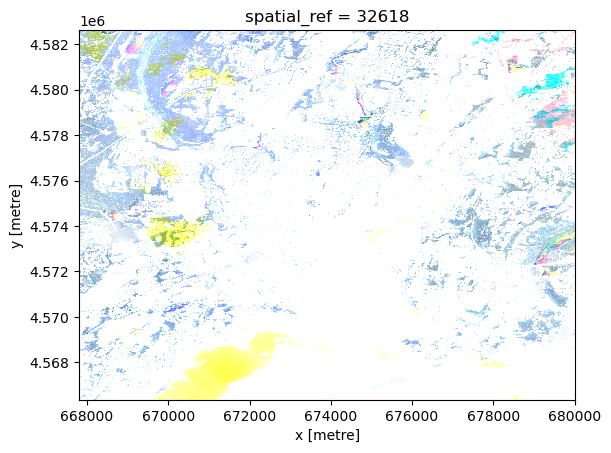

In [125]:
import cartopy.crs as ccrs

p = data.red.plot.imshow()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1..15831].


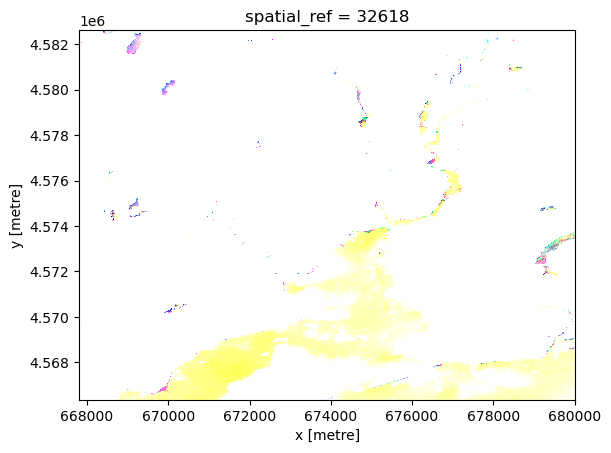

In [87]:
data.nir08.plot.imshow()

In [42]:
ndvi = (
    ((data.nir08 - data.red) / (data.red + data.nir08))
    .median("time", keep_attrs=True)
)

ndvi = ndvi.where(ndvi < 1).compute()

ndvi

<xarray.DataArray (y: 1627, x: 1220)> Size: 16MB
array([[0.88591885, 0.88051675, 0.87161283, ..., 0.85875371, 0.84881165,
        0.86324397],
       [0.85873743, 0.88231669, 0.90861641, ..., 0.75906042, 0.82126435,
        0.84697593],
       [0.84439895, 0.88673668, 0.89681533, ..., 0.77134877, 0.82810371,
        0.84242071],
       ...,
       [0.81399746, 0.45830669, 0.36016143, ...,        nan,        nan,
               nan],
       [0.8458809 , 0.48283024, 0.41006737, ...,        nan,        nan,
               nan],
       [0.82337862, 0.4601535 , 0.44678909, ...,        nan,        nan,
               nan]], shape=(1627, 1220))
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618
Attributes:
    nodata:   0

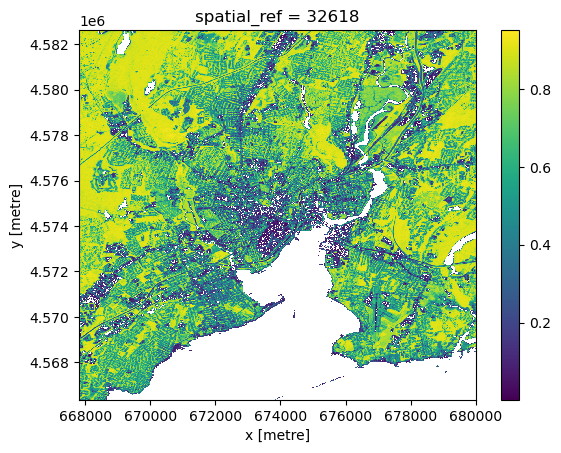

In [49]:
# TODO: (nitpick) Why is it blurry even when I set no/nearest interpolation?
# It's blurry on Carl's website too. I feel like I've solved this before... :)
ndvi.plot.imshow()

In [93]:
import rioxarray

ndvi.rio.reproject(
    "EPSG:4326",
).rio.to_raster(
    raster_path=DATA_DIR / "ndvi.tif", 
    driver="COG",
)

### Zonal statistics

https://espm-288.carlboettiger.info/tutorials/python/spatial-4.html

In [138]:
from exactextract import exact_extract

city_stats = exact_extract(
    DATA_DIR / "ndvi.tif", 
    city, 
    "mean_ndvi=mean", 
    include_geom = True,
    include_cols=["label", "grade", "city", "fill"],
    output="pandas",
)

city_stats.head()

,label,grade,city,fill,mean_ndvi,geometry
0,A1,A,New Haven,#76a865,0.709624,"MULTIPOLYGON (((-72.9 41.36885, -72.90325 41.3..."
1,A2,A,New Haven,#76a865,0.761685,"MULTIPOLYGON (((-72.89401 41.36331, -72.89256 ..."
2,A3,A,New Haven,#76a865,0.665130,"MULTIPOLYGON (((-72.90981 41.35949, -72.90284 ..."
3,A4,A,New Haven,#76a865,0.751388,"MULTIPOLYGON (((-72.90284 41.35795, -72.8999 4..."
4,A5,A,New Haven,#76a865,0.742981,"MULTIPOLYGON (((-72.89801 41.3493, -72.89883 4..."


In [133]:
city_stats.explore(column="mean")

TODO: JupyterGIS-ify